## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
# random seed for Torch and NumPy

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

## Load Data

Let's load in our data from the csv files into a pandas dataframe.

In [2]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting data

We further split our data into training and valudation sets. I've done it manually here, using a 80-20 split. While for this competition it may work, in general it is better to randomize this split.

In [4]:
feature_train_tensor = torch.tensor(df_train.drop('label', axis=1)[0:33600].to_numpy())
label_train_tensor = torch.tensor(df_train.loc[:33599, 'label'].to_numpy())

feature_val_tensor = torch.tensor(df_train.drop('label', axis=1)[33600:].to_numpy())
label_val_tensor = torch.tensor(df_train.loc[33600:, 'label'].to_numpy())

test_tensor = torch.tensor(df_test.to_numpy())

A simple normalization to keep the values between 0 and 1.

In [5]:
feature_train_tensor = feature_train_tensor.float() / 255.0
feature_val_tensor = feature_val_tensor.float() / 255.0
test_tensor = test_tensor.float() / 255.0

In [6]:
feature_train_tensor.shape, label_train_tensor.shape

(torch.Size([33600, 784]), torch.Size([33600]))

In [7]:
train_dataset = TensorDataset(feature_train_tensor, label_train_tensor)
val_dataset = TensorDataset(feature_val_tensor, label_val_tensor)
test_dataset = TensorDataset(test_tensor)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, collate_fn=None)

In [8]:
feature, label = next(iter(train_loader))
type(feature), type(label)

(torch.Tensor, torch.Tensor)

In [9]:
feature = next(iter(test_loader))[0]
feature.shape

torch.Size([128, 784])

In [10]:
feature, label = next(iter(train_dataset))
feature.shape

torch.Size([784])

## Having a look at our dataset

Let's have a look at some of our training dataset alongside their labels, we can use matplotlib to do some simple plotting.

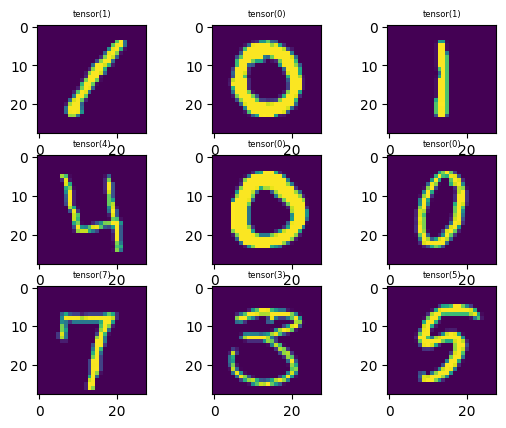

In [11]:
iter_dataset = iter(train_dataset)
for i in range(9):
    plt.subplot(3, 3, i +1)
    feature, label = next(iter_dataset)
    plt.imshow(feature.reshape(28, 28))
    plt.title(label, fontsize=6)

## Writing our training function

In [12]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    model.train()

    losses = []

    for idx, data in enumerate(train_loader):
        
        features, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())       
        # print(f"Batch ID: {idx} \t Loss: {loss.item()}")
    return losses

# Writing our evaluation function

In [13]:
def evaluate(dataloader, model, criterion, device):
    model.eval() # weights are not updated

    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_loss = 0
        
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            loss = criterion(outputs, labels) # we need val loss
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_correct += (preds==labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples * 100

    return avg_loss, accuracy
    

In [14]:
def train_modelcv(train_loader, test_loader, model, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    best_measure = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)
        
        train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, measure = evaluate(test_loader, model, criterion, device)
        val_losses.append(val_loss)

        print("Performance measure: ", measure)

        if measure > best_measure:
            best_weights = model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print(f"Current Best is epoch {best_epoch} with {best_measure} %")

    return best_weights, best_measure, best_epoch, train_losses, val_losses

        
        

# Building our model

Here comes the fun part, actually building our Model! I'm going to build a simple convolutional neural network with some fully connected layers. We can further tune our model in the future.

In [15]:
class CustomModel(nn.Module):

    def __init__(self, indims, numcl):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)

        self.pool = nn.MaxPool2d(2, stride=1) # let's keep it stride of 1 for simple calculations eh

        self.fc1 = nn.Linear(256 * 19 * 19, 100)
        self.fc2 = nn.Linear(100, numcl)

    def forward(self, x):
        x = x.reshape(x.size(0), -1, 28, 28)
        v = F.relu(self.pool(self.conv1(x)))
        v = F.relu(self.pool(self.conv2(v)))
        v = F.relu(self.pool(self.conv3(v)))

        v = v.view(-1, 256*19*19)
        v = F.relu(self.fc1(v))
        v = self.fc2(v)

        return v
        
        

# Hyperparameters

In [16]:
num_epochs = 30
lr = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = torch.nn.CrossEntropyLoss()

model = CustomModel(784, 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Main Loop

Where the action is...

In [17]:
best_weights, best_measure, best_epoch, train_losses, val_losses = train_modelcv(train_loader,
                                                                                 val_loader,
                                                                                 model, 
                                                                                 loss, 
                                                                                 optimizer,
                                                                                 num_epochs,
                                                                                 device)

                                                                                 

Epoch 0/29
----------
Performance measure:  96.4047619047619
Current Best is epoch 0 with 96.4047619047619 %
Epoch 1/29
----------
Performance measure:  97.05952380952381
Current Best is epoch 1 with 97.05952380952381 %
Epoch 2/29
----------
Performance measure:  97.63095238095238
Current Best is epoch 2 with 97.63095238095238 %
Epoch 3/29
----------
Performance measure:  96.75
Epoch 4/29
----------
Performance measure:  97.98809523809524
Current Best is epoch 4 with 97.98809523809524 %
Epoch 5/29
----------
Performance measure:  98.25
Current Best is epoch 5 with 98.25 %
Epoch 6/29
----------
Performance measure:  98.29761904761905
Current Best is epoch 6 with 98.29761904761905 %
Epoch 7/29
----------
Performance measure:  98.07142857142857
Epoch 8/29
----------
Performance measure:  98.27380952380952
Epoch 9/29
----------
Performance measure:  97.94047619047619
Epoch 10/29
----------
Performance measure:  98.27380952380952
Epoch 11/29
----------
Performance measure:  97.8809523809523

# Plot training and validation loss

In [25]:
def plot_train_val_loss(train_loss, val_loss):
    # get average loss for training and validation
    t_losses = [np.mean(i) for i in train_loss]
    v_losses = [np.mean(i) for i in val_loss]
    plt.plot(t_losses, label='train loss')
    plt.plot(v_losses, label='val loss')
    plt.legend()
    plt.show()

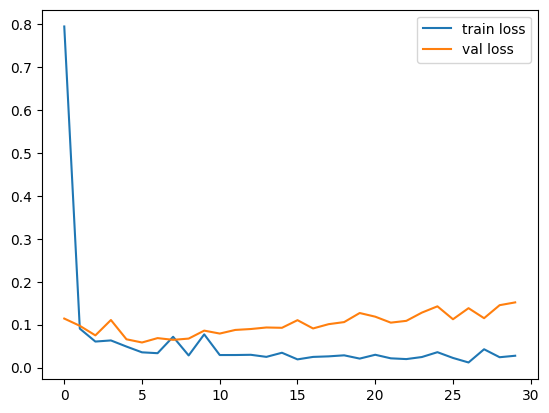

In [26]:
plot_train_val_loss(train_losses, val_losses)

In [27]:
# load model with best weights
model.load_state_dict(best_weights)
model.eval()
predictions = []
with torch.no_grad():
    for features in test_loader:
        features = features[0].to(device)
        outputs = model(features)

        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

image_id = [i for i in range(1, len(predictions)+1)]
submission_df = pd.DataFrame({
    "ImageId": image_id,
    "Label": predictions
})

submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [28]:
submission_df.to_csv("../data/submission1.csv", index=False)